### Importing Libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

### EDA(Exploratory Data Analysis)

In [2]:
df = pd.read_csv("trans.txt", sep=";", error_bad_lines=False)

In [3]:
df.head(1)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,637742,2177,930105,PRIJEM,PREVOD Z UCTU,5123.0,5923.0,DUCHOD,YZ,62457513


In [4]:
df.nunique()

trans_id      273508
account_id      3712
date             717
type               2
operation          2
amount          5631
balance       216346
k_symbol           5
bank              13
account         7664
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273508 entries, 0 to 273507
Data columns (total 10 columns):
trans_id      273508 non-null int64
account_id    273508 non-null int64
date          273508 non-null int64
type          273508 non-null object
operation     273508 non-null object
amount        273508 non-null float64
balance       273508 non-null float64
k_symbol      230465 non-null object
bank          273508 non-null object
account       273508 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 20.9+ MB


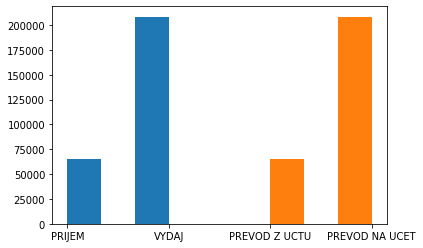

In [6]:
plt.hist(df['type'], bins=3);
plt.hist(df['operation'], bins=3);

In [7]:
print(df.type.unique())
print(df.operation.unique())

['PRIJEM' 'VYDAJ']
['PREVOD Z UCTU' 'PREVOD NA UCET']


### Data transformation

In [8]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
#Work on the Categorical Values 
df['type'] = LE.fit_transform(df['type'])

In [9]:
dummy = pd.get_dummies(df['bank'])

In [10]:
# Drop columns 
# dropping k-symbol as it has data rows missing
# dropping operations as its 100% correlated to "type"
# dropping bank as we created dummy variables for all 13 types
# dropping account as it represents accounts at other banks and not ueful for clustering
df=df.drop(['k_symbol','bank','operation','trans_id','account_id','account'] ,axis=1)

In [11]:
df = pd.concat([df,dummy],axis=1)
df.shape

(273508, 17)

### Checking for Correlation 

In [12]:
corr = df.corr()
corr = corr.iloc[:4,:4]
corr

,date,type,amount,balance
date,1.000000,0.050066,-0.019042,0.073515
type,0.050066,1.000000,-0.454806,-0.004584
amount,-0.019042,-0.454806,1.000000,0.456050
balance,0.073515,-0.004584,0.456050,1.000000


### Standardizing the Data

In [13]:
from sklearn.preprocessing import StandardScaler
X=df
X = StandardScaler().fit_transform(X)

### Determining optimal number of clusters

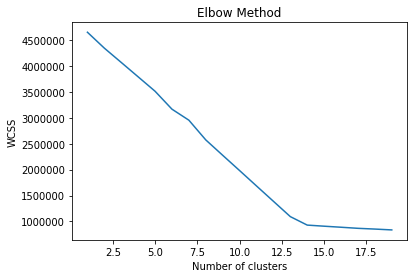

In [14]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Splitting the Dataset

In [15]:
from sklearn.model_selection import train_test_split

Xhalf1, Xhalf2 = train_test_split(X,test_size=0.5, random_state=42)
# Then we halve the halves.
X1, X2 = train_test_split( Xhalf1, test_size=0.5, random_state=42)
X3, X4 = train_test_split( Xhalf2, test_size=0.5, random_state=42)

### Running Kmeans with clusters 2 to 15

In [20]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans

Xsplit = list()
for i in range(2, 15):
    result = list()
    
    for sample in [X1,X2,X3,X4]:
        labels = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42).fit_predict(sample)
        result.append(metrics.silhouette_score(sample, labels, metric='euclidean'))

    Xsplit.append(np.mean(result))
    print("Number of estimated clusters: " + str(i) + ", score: " + str(np.mean(result))+", std: " + str(np.std(result)))

Number of estimated clusters: 2, score: 0.20152135495887177, std: 0.0001645661053750913
Number of estimated clusters: 3, score: 0.145070625212839, std: 0.031324647571078265
Number of estimated clusters: 4, score: 0.16235848564271602, std: 0.023645396151447146
Number of estimated clusters: 5, score: 0.21828975703333503, std: 0.0144668022414456
Number of estimated clusters: 6, score: 0.2574992660274604, std: 0.002471313119848962
Number of estimated clusters: 7, score: 0.31957196201964544, std: 0.0007779694028112852
Number of estimated clusters: 8, score: 0.36196150404791755, std: 0.0013915354379465486
Number of estimated clusters: 9, score: 0.40570800587099565, std: 0.0007733947717600579
Number of estimated clusters: 10, score: 0.44869044074482534, std: 0.017908876203513766
Number of estimated clusters: 11, score: 0.5212613986397718, std: 0.0013709834435861512
Number of estimated clusters: 12, score: 0.5659437892830632, std: 0.00035866141515151974
Number of estimated clusters: 13, score:

####  k-means++ ensures that you get don’t fall into the random initialization trap.
#### We validated that 13 is the optimal numbers of clusters

#### Checking for stability within the 13 clusters k means

In [18]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
for sample in [X1,X2,X3,X4]:
    model = KMeans(n_clusters=13, init='k-means++', max_iter=300, n_init=10, random_state=42).fit_predict(sample)
    print(metrics.silhouette_score(sample, model, metric='euclidean'))

0.610742867784756
0.6102624951246207
0.6125737668373789
0.6111315156690366


In [28]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
modelX = KMeans(n_clusters=13, init='k-means++', max_iter=300, n_init=10, random_state=42).fit_predict(X)
print(metrics.silhouette_score(X, modelX, metric='euclidean'))

0.5911012031284356


#### The above analysis determines that the model is Stable

### Finding Centres for the Clusters

In [17]:
model_fit = KMeans(n_clusters=13, random_state=42).fit(X)
centres = model_fit.cluster_centers_
df_centres =pd.DataFrame(centres, columns=df.columns)
df_centres

,date,type,amount,balance,AB,CD,EF,GH,IJ,KL,MN,OP,QR,ST,UV,WX,YZ
0,-0.019031,-0.034877,-0.015137,-0.001736,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,-0.290121,-0.278012,3.459213,-0.297836,-0.293640,-0.289625,-0.282225,-0.292691
1,-0.021951,-0.017675,0.066116,0.004896,-0.293706,-0.277814,-0.290558,3.423725,-0.284837,-0.290121,-0.278012,-0.289083,-0.297836,-0.293640,-0.289625,-0.282225,-0.292691
2,0.003092,0.014119,-0.009084,0.026187,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,-0.290121,-0.278012,-0.289083,-0.297836,-0.293640,-0.289625,-0.282225,3.416573
3,-0.001631,0.014241,-0.012884,-0.013211,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,3.446834,-0.278012,-0.289083,-0.297836,-0.293640,-0.289625,-0.282225,-0.292691
4,0.037315,0.029194,-0.032789,0.009829,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,-0.290121,-0.278012,-0.289083,-0.297836,-0.293640,-0.289625,3.543270,-0.292691
5,0.034115,0.049333,-0.002914,-0.036780,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,-0.290121,-0.278012,-0.289083,3.357557,-0.293640,-0.289625,-0.282225,-0.292691
6,0.000615,-0.011320,0.038064,0.033202,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,-0.290121,-0.278012,-0.289083,-0.297836,-0.293640,3.452743,-0.282225,-0.292691
7,0.043874,-0.051100,-0.054594,-0.044152,-0.293706,-0.277814,-0.290558,-0.292080,-0.284837,-0.290121,3.596962,-0.289083,-0.297836,-0.293640,-0.289625,-0.282225,-0.292691
8,-0.019620,-0.002082,0.016593,0.004215,-0.293706,-0.277814,-0.290558,-0.292080,3.510784,-0.290121,-0.278012,-0.289083,-0.297836,-0.293640,-0.289625,-0.282225,-0.292691
9,0.000138,-0.037182,-0.000313,0.027941,-0.293706,3.599531,-0.290558,-0.292080,-0.284837,-0.290121,-0.278012,-0.289083,-0.297836,-0.293640,-0.289625,-0.282225,-0.292691


####  Variables Date,Type of transaction and Balance have the highest weights of importance, in that order

### Fitting the model in 2 dimensions with PCA

In [17]:
from sklearn.decomposition import PCA
pca=PCA(2).fit(X)

#### Plotting the clusters Using the Orignal model labels with PCA

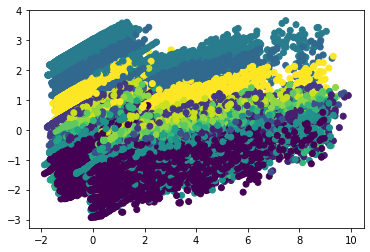

In [29]:
from sklearn.decomposition import PCA
# Reduce it to two components.
X_pca = PCA(2).fit_transform(X)

# Calculate predicted values.
labels_pca = KMeans(n_clusters=13, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=modelX)
plt.show()

#### Finding Cluster Centres

In [26]:
kmeans = KMeans(n_clusters=13,init ='k-means++', random_state=42).fit(X_pca)
centres = kmeans.cluster_centers_
pca_centres =pd.DataFrame(centres, columns=['x','y'])
pca_centres

,x,y
0,-0.047801,0.716554
1,0.529204,-0.904991
2,4.765625,-0.064490
3,-0.726244,-0.761292
4,-0.894429,0.726042
5,6.620878,0.896425
6,0.606004,0.083826
7,0.638359,1.684216
8,-0.752255,-1.673285
9,0.622315,-2.088305


### Plotting the clusters using PCA labels with Cluster Centres

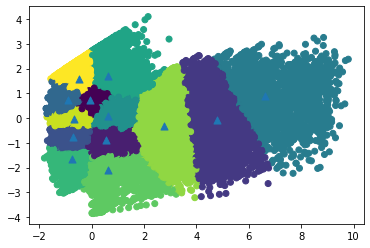

In [27]:
A = pca_centres['x']
B = pca_centres['y']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca)
plt.scatter(A, B, s=50, markerfacecolor='blue', markersize=12, marker='^')
plt.show()

#### We can see that the visual with orignal data labels is very messy, due to the fact its multi dimesional. Its hard to represnt it in 2 dimensions. But the visual using PCA labels is clear.

### Modelling and plotting using TSNE

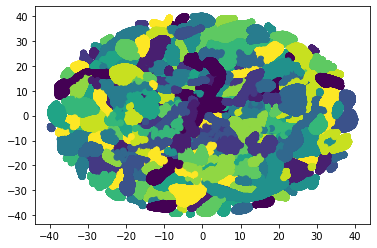

In [25]:
from sklearn.manifold import TSNE
X_tsne = TSNE(random_state=42).fit_transform(X)
labels_tsne = KMeans(n_clusters=13, random_state=42).fit_predict(X_tsne)
# Plot the solution.
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=modelX)
plt.show()

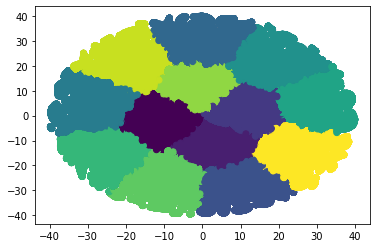

In [26]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne)
plt.show()

#### Linear dimensionality reduction algorithms, like PCA, concentrate on placing dissimilar data points far apart in a lower dimension representation (as we can see in our plot above). But in order to represent high dimension data on low dimension, non-linear manifold, it is essential that similar data points must be represented close together, which is something t-SNE does not PCA.